# Đồ án cuối kỳ
# Môn: Xử lý dữ liệu lớn
# Học kỳ 1 - Năm học 2022-2023
# Giảng viên: Th.S. Nguyễn Thành An

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cài đặt PySpark

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!cp drive/MyDrive/tmp/spark-3.1.1-bin-hadoop3.2.tgz .
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

cp: cannot stat 'drive/MyDrive/tmp/spark-3.1.1-bin-hadoop3.2.tgz': No such file or directory


In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark
findspark.init()

# Yêu cầu

## Spark Context

In [4]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

sc = SparkContext("local", 'CK')
sqlc = SQLContext(sc)

## Câu 1: Giảm số chiều với SVD

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.sql import Row

def preprocess(x):
    x = x.split(',')
    matrix = np.array(x[2:]).astype(np.int)
    return (int(x[0]),int(x[1]),matrix)


rdd_train = sc.textFile("/content/drive/MyDrive/New Version/oxford_pet3_train.csv") #rdd to taming
rdd_test = sc.textFile("/content/drive/MyDrive/New Version/oxford_pet3_test.csv")
rdd_display_images = rdd_train.map(preprocess)\
                              .map(lambda x: (x[0],x[1],x[2].reshape(128,128,3)))
     
# df = sqlc.read.option("maxColumns",50000).csv("/content/drive/MyDrive/datasets/oxford_pet3_train.csv")

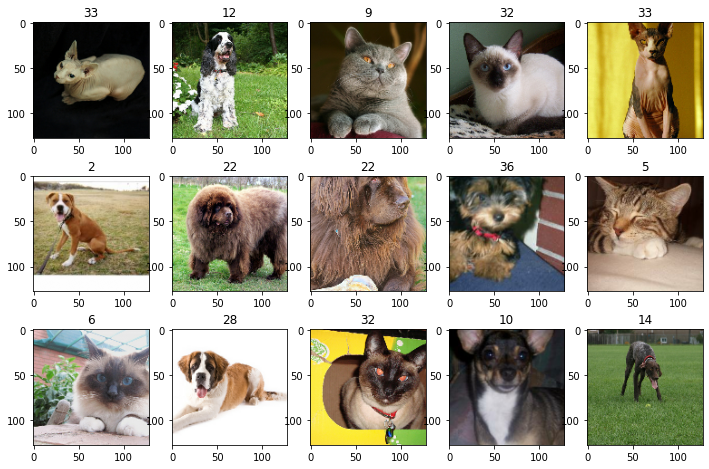

In [6]:
def plot_images_grid(rdd,rows):
    r = rdd.take(rows)
    fig = plt.figure(figsize = (12,8))
    for i in range(rows):
        title,image = r[i][1],r[i][2]
        plt.subplot(3,5,i+1)
        plt.imshow(image/255)
        plt.title(title)
    fig.show()
plot_images_grid(rdd_display_images,15)

In [8]:
#1.1
rows = rdd_train.map(preprocess)\
                 .map(lambda v: Vectors.dense(v[2]))
#pick r = 100
mat = RowMatrix(rows)
svd = mat.computeSVD(80, computeU=True)
U = svd.U
s = svd.s
V = svd.V

In [9]:
l = np.array(U.rows.collect()) #out of method :^)
sig = np.array(s)
r = np.array(V.toArray()).transpose()
print(l.shape)
print(sig.shape)
print(r.shape)


(500, 80)
(80,)
(80, 49152)


In [10]:
#reduce quality of image
rec_mat = l @ np.diag(sig) @ r
rec_mat.shape

(500, 49152)

In [11]:
pet3_r80_train = rdd_train.map(preprocess)\
                   .map(lambda x: (x[0],x[1], str([float(n) for n in rec_mat[x[0]]])))\
                   .toDF()

In [13]:
!rm -rf "/content/drive/MyDrive/datasets/oxford_pet3_80_train.csv"
pet3_r80_train.repartition(1).write.csv('/content/drive/MyDrive/datasets/oxford_pet3_80_train.csv')

In [14]:
df = sqlc.read.csv("/content/drive/MyDrive/datasets/oxford_pet3_80_train.csv")
df.show()

+---+---+--------------------+
|_c0|_c1|                 _c2|
+---+---+--------------------+
|  0| 33|[11.2485358633465...|
|  1| 12|[20.5779916161160...|
|  2|  9|[12.2953497514603...|
|  3| 32|[104.467091904726...|
|  4| 33|[234.462074508373...|
|  5|  2|[186.288582218599...|
|  6| 22|[182.895838829834...|
|  7| 22|[135.102005692965...|
|  8| 36|[55.9788320216787...|
|  9|  5|[56.3647122849480...|
| 10|  6|[175.741976022630...|
| 11| 28|[235.354870458183...|
| 12| 32|[167.915536528234...|
| 13| 10|[30.3593886657564...|
| 14| 14|[77.8572907709398...|
| 15|  3|[32.3623421192620...|
| 16| 22|[136.257473434922...|
| 17| 12|[27.8430395051883...|
| 18| 32|[76.7253793715973...|
| 19|  5|[209.856118307185...|
+---+---+--------------------+
only showing top 20 rows



In [18]:
# #1.2
rows = rdd_test.map(preprocess)\
                 .map(lambda v: v[2])
mat = RowMatrix(rows)


In [19]:
svd = mat.computeSVD(80, computeU=True)
U_test = svd.U
s_test = svd.s
V_test = svd.V

In [42]:
l_test = np.array(U_test.rows.collect())
sig_test = np.array(s_test)
r_test = np.array(V_test.toArray()).transpose()

rec_mat_test = l_test @ np.diag(sig_test) @ r_test
print(rec_mat_test.shape)
#reformat to save as csv 
#((title,row),index) -> index,  title, row
pet3_r100_test = rdd_train.map(preprocess)\
                   .map(lambda x: (x[0],x[1], str([float(n) for n in rec_mat_test[x[0]]])))\
                   .toDF()

!rm -rf "/content/drive/MyDrive/datasets/oxford_pet3_80_test.csv"
pet3_r100_test.repartition(1).write.csv('/content/drive/MyDrive/datasets/oxford_pet3_80_test.csv')


(500, 49152)


## Câu 2: Khuyến nghị sản phẩm với Collaborative Filtering

In [64]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
ratingsRDD = sqlc.read.csv('/content/drive/MyDrive/ratings2k.csv',header = "True")\
                 .rdd\
                 .map(lambda x:Row(index = int(x[0]),user = int(x[1]),item = int(x[2]), rating = float(x[3])))
ratings = sqlc.createDataFrame(ratingsRDD).orderBy("user")

ratings.printSchema()
ratings.show()

root
 |-- index: long (nullable = true)
 |-- user: long (nullable = true)
 |-- item: long (nullable = true)
 |-- rating: double (nullable = true)

+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
|  390|   1| 352|   5.0|
|   32|   1| 167|   3.5|
| 1188|   1| 168|   5.0|
|  130|   1| 422|   3.5|
| 1544|   1| 163|   5.0|
|  674|   2| 288|   5.0|
| 1568|   2| 216|   1.0|
|  482|   2| 251|   5.0|
|  757|   2| 204|   4.5|
|   50|   2| 413|   3.5|
| 1108|   2| 310|   2.0|
|  139|   2| 183|   5.0|
| 1274|   2| 199|   4.5|
| 1485|   2| 271|   4.0|
| 1622|   2| 294|   4.5|
| 1097|   2|  82|   4.5|
| 1180|   2| 176|   5.0|
| 1213|   2|   0|   3.5|
| 1399|   2| 320|   2.0|
|  238|   2| 434|   4.0|
+-----+----+----+------+
only showing top 20 rows



In [65]:
test = ratings.filter(ratings.user > 70) #4 last user
train = ratings

In [66]:
from pyspark.ml.recommendation import ALS
als = ALS(rank = 5,
          maxIter = 5,
          userCol="user", 
          itemCol="item", 
          ratingCol="rating",
          numUserBlocks = 70,
          regParam = 0.01)
model = als.fit(train)

In [67]:
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="mse", labelCol="rating",
                                predictionCol="prediction")
mse = evaluator.evaluate(predictions)
print("MSE = ",mse)

MSE =  0.19381224376720063


In [68]:
predictions.show()

+-----+----+----+------+----------+
|index|user|item|rating|prediction|
+-----+----+----+------+----------+
|  276|  75| 148|   3.0| 2.5445342|
|  868|  72|  85|   3.0| 3.0942104|
|  140|  72| 251|   5.0| 4.1459146|
|  146|  75| 251|   4.0| 4.0674276|
|  463|  71| 251|   5.0| 5.4261575|
| 1931|  74| 251|   4.0|  3.488337|
| 2208|  72| 451|   4.0| 4.1256137|
| 2075|  72| 255|   3.0| 3.1679611|
|  565|  72| 322|   4.0|  3.928509|
|  311|  75| 322|   4.0| 3.9876685|
| 2202|  71| 322|   5.0|  5.201237|
| 1617|  74| 322|   3.0|  3.366821|
| 1505|  72| 321|   2.0| 2.9125924|
|  919|  75| 321|   5.0| 3.2928898|
|  962|  72| 108|   2.0| 2.0628068|
| 1754|  72|  34|   4.0| 3.9747963|
| 1433|  75|  34|   3.5| 3.8938198|
| 1270|  72| 193|   4.0|   4.14925|
| 1958|  75| 193|   3.0| 3.0069091|
|  665|  74| 193|   1.0| 1.1009812|
+-----+----+----+------+----------+
only showing top 20 rows



In [69]:
predictions.printSchema()
print("Pearson Correlation: ",end="")
predictions.corr("rating","prediction")

root
 |-- index: long (nullable = true)
 |-- user: long (nullable = true)
 |-- item: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- prediction: float (nullable = false)

Pearson Correlation: 

0.9135376220745998

## Câu 3: Dự đoán giá chứng khoán

In [21]:
from pyspark.sql.types import StructType, FloatType, StringType
schema = StructType() \
          .add("Ngay", StringType(), True) \
          .add("HVN", FloatType(), True)
df = sqlc.read.option("header",True).schema(schema).csv("/content/stockHVN2022.csv")

In [22]:
# Lấy dữ liệu tháng 1-8 làm tập train và từ tháng 9 trở lên làm tập test
def splitData(rdd):
  dataForTrain = []
  dataForTest = []
  for row in range(len(rdd)):
    month = int(rdd[row][0].split("/")[1])
    if month > 8:
      dataForTest.append([rdd[row][0], rdd[row][1]])
    else:
      dataForTrain.append([rdd[row][0], rdd[row][1]])
  return (dataForTrain,dataForTest)

# Chuyển đổi dữ liệu thành dạng cứ 5 ngày sẽ dự đoán 1 ngày
def convertDataForModel(data):
  result = []
  for i in range(len(data)-5):
    result.append([data[i+1][1],data[i+2][1],data[i+3][1],data[i+4][1],data[i+5][1],data[i][1]])
  return result

In [23]:
rdd = df.rdd.map(lambda x: x).collect()
dataForTrain = splitData(rdd)[0]
dataForTest = splitData(rdd)[1]

In [24]:
# Tạo dataframe cho tập train
df_train_data = sqlc.createDataFrame(convertDataForModel(dataForTrain),["Day1","Day2","Day3","Day4","Day5","Nextday"])

# Tạo dataframe cho tập test
df_test_data = sqlc.createDataFrame(convertDataForModel(dataForTest),["Day1","Day2","Day3","Day4","Day5","Nextday"])

df_train_data.show()

+------------------+------------------+------------------+------------------+------------------+------------------+
|              Day1|              Day2|              Day3|              Day4|              Day5|           Nextday|
+------------------+------------------+------------------+------------------+------------------+------------------+
|17.100000381469727|17.049999237060547|17.649999618530273|17.899999618530273|17.899999618530273|             17.25|
|17.049999237060547|17.649999618530273|17.899999618530273|17.899999618530273|17.450000762939453|17.100000381469727|
|17.649999618530273|17.899999618530273|17.899999618530273|17.450000762939453|17.399999618530273|17.049999237060547|
|17.899999618530273|17.899999618530273|17.450000762939453|17.399999618530273|17.399999618530273|17.649999618530273|
|17.899999618530273|17.450000762939453|17.399999618530273|17.399999618530273|17.350000381469727|17.899999618530273|
|17.450000762939453|17.399999618530273|17.399999618530273|17.35000038146

In [25]:
from pyspark.ml.feature import VectorAssembler

# Chuyển các feature cho model học dưới dạng vector
featureassembler = VectorAssembler(inputCols=["Day1","Day2","Day3","Day4","Day5"],outputCol="Independent Features")

df_train_data = featureassembler.transform(df_train_data)
df_test_data = featureassembler.transform(df_test_data)

df_train_data.show()

+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+
|              Day1|              Day2|              Day3|              Day4|              Day5|           Nextday|Independent Features|
+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+
|17.100000381469727|17.049999237060547|17.649999618530273|17.899999618530273|17.899999618530273|             17.25|[17.1000003814697...|
|17.049999237060547|17.649999618530273|17.899999618530273|17.899999618530273|17.450000762939453|17.100000381469727|[17.0499992370605...|
|17.649999618530273|17.899999618530273|17.899999618530273|17.450000762939453|17.399999618530273|17.049999237060547|[17.6499996185302...|
|17.899999618530273|17.899999618530273|17.450000762939453|17.399999618530273|17.399999618530273|17.649999618530273|[17.8999996185302...|
|17.899999618530273|17.450000762939453|17

In [26]:
# Chỉ giữ 2 cột Features và kết quả cho các dataframe cho mô hình học và dự đoán
train_data = df_train_data.select("Independent Features","Nextday")
test_data = df_test_data.select("Independent Features","Nextday")

train_data.show()

+--------------------+------------------+
|Independent Features|           Nextday|
+--------------------+------------------+
|[17.1000003814697...|             17.25|
|[17.0499992370605...|17.100000381469727|
|[17.6499996185302...|17.049999237060547|
|[17.8999996185302...|17.649999618530273|
|[17.8999996185302...|17.899999618530273|
|[17.4500007629394...|17.899999618530273|
|[17.3999996185302...|17.450000762939453|
|[17.3999996185302...|17.399999618530273|
|[17.3500003814697...|17.399999618530273|
|[17.3500003814697...|17.350000381469727|
|[17.7000007629394...|17.350000381469727|
|[17.6499996185302...|17.700000762939453|
|[17.8500003814697...|17.649999618530273|
|[17.7999992370605...|17.850000381469727|
|[18.1000003814697...|17.799999237060547|
|[17.5499992370605...|18.100000381469727|
|[17.6000003814697...|17.549999237060547|
|[17.7999992370605...|17.600000381469727|
|[17.1000003814697...|17.799999237060547|
|[17.0499992370605...|17.100000381469727|
+--------------------+------------

In [27]:
from pyspark.ml.regression import LinearRegression

# Xây dựng mô hình Linear Regression 
regressor = LinearRegression(featuresCol='Independent Features', labelCol='Nextday')
regressor = regressor.fit(train_data)

In [28]:
# Dự đoán kết quả đối với tập train
pred_results_train = regressor.evaluate(train_data)
pred_results_train.predictions.show()

+--------------------+------------------+------------------+
|Independent Features|           Nextday|        prediction|
+--------------------+------------------+------------------+
|[17.1000003814697...|             17.25|17.153309991632323|
|[17.0499992370605...|17.100000381469727| 17.09404553004526|
|[17.6499996185302...|17.049999237060547|17.631954486885153|
|[17.8999996185302...|17.649999618530273|17.843904760661808|
|[17.8999996185302...|17.899999618530273| 17.93048536357782|
|[17.4500007629394...|17.899999618530273|17.445659516454693|
|[17.3999996185302...|17.450000762939453|17.325259991838923|
|[17.3999996185302...|17.399999618530273|17.399598897962125|
|[17.3500003814697...|17.399999618530273|17.341683127360668|
|[17.3500003814697...|17.350000381469727|17.312126745594203|
|[17.7000007629394...|17.350000381469727|17.661468128349224|
|[17.6499996185302...|17.700000762939453|17.708736498786223|
|[17.8500003814697...|17.649999618530273| 17.87009558639704|
|[17.7999992370605...|17

In [29]:
# Dự đoán kết quả đối với tập test
pred_results_test = regressor.evaluate(test_data)
pred_results_test.predictions.show()

+--------------------+------------------+------------------+
|Independent Features|           Nextday|        prediction|
+--------------------+------------------+------------------+
|[9.42000007629394...| 9.300000190734863| 9.304337879644574|
|[9.21000003814697...| 9.420000076293945|  9.38895466895402|
|[8.60999965667724...| 9.210000038146973| 8.560672418305863|
|[9.25,9.899999618...| 8.609999656677246|  9.24499906326457|
|[9.89999961853027...|              9.25| 10.04607881464039|
|[9.76000022888183...| 9.899999618530273| 9.631059599992845|
|[10.3999996185302...| 9.760000228881836|10.404038362697172|
|[10.25,10.1000003...|10.399999618530273|10.352005238708392|
|[10.1000003814697...|             10.25| 10.10345362582847|
|[10.6999998092651...|10.100000381469727|10.746637052085132|
|[10.8500003814697...|10.699999809265137| 10.89196448038465|
|[10.8999996185302...|10.850000381469727|10.909417618130497|
|[10.8999996185302...|10.899999618530273|10.990655681027235|
|[10.8000001907348...|10

In [30]:
# Tính độ đo MSE cho tập train và test
print("Mean squared error of train data",pred_results_train.meanSquaredError)
print("Mean squared error of test data",pred_results_test.meanSquaredError)

Mean squared error of train data 0.19694910868467175
Mean squared error of test data 0.129352449053747


## Câu 4: Phân loại đa lớp với pyspark

In [53]:
from pyspark.ml.linalg import Vectors as ml_vectors
import numpy as np
def f(x):
  k = x.split(',')
  return int(k[1]), ml_vectors.dense(np.array(k[2:]).astype(int))

In [ ]:
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Data gốc
pet3_train = sc.textFile('/content/drive/MyDrive/New Version/oxford_pet3_train.csv').map(f).toDF(['label', 'features'])
pet3_test = sc.textFile('/content/drive/MyDrive/New Version/oxford_pet3_test.csv').map(f).toDF(['label', 'features'])

In [62]:
# Data đã chỉnh số chiều ở câu 1
df1 = sqlc.read.csv("/content/drive/MyDrive/datasets/oxford_pet3_80_train.csv")
df2 = sqlc.read.csv("/content/drive/MyDrive/datasets/oxford_pet3_80_test.csv")
# df.show()
pet3_r80_train = df1.rdd.map(lambda x: (int(x[0]),int(x[1]),list(map(float,(x[2][1:-1].split(',')))))).toDF(['ID','label', 'features'])
pet3_r80_test = df2.rdd.map(lambda x: (int(x[0]),int(x[1]),list(map(float,(x[2][1:-1].split(',')))))).toDF(['ID','label', 'features'])
pet3_r80_train.show()
pet3_r80_test.show()

+---+-----+--------------------+
| ID|label|            features|
+---+-----+--------------------+
|  0|   33|[11.2485358633465...|
|  1|   12|[20.5779916161160...|
|  2|    9|[12.2953497514603...|
|  3|   32|[104.467091904726...|
|  4|   33|[234.462074508373...|
|  5|    2|[186.288582218599...|
|  6|   22|[182.895838829834...|
|  7|   22|[135.102005692965...|
|  8|   36|[55.9788320216787...|
|  9|    5|[56.3647122849480...|
| 10|    6|[175.741976022630...|
| 11|   28|[235.354870458183...|
| 12|   32|[167.915536528234...|
| 13|   10|[30.3593886657564...|
| 14|   14|[77.8572907709398...|
| 15|    3|[32.3623421192620...|
| 16|   22|[136.257473434922...|
| 17|   12|[27.8430395051883...|
| 18|   32|[76.7253793715973...|
| 19|    5|[209.856118307185...|
+---+-----+--------------------+
only showing top 20 rows

+---+-----+--------------------+
| ID|label|            features|
+---+-----+--------------------+
|  0|   33|[216.122411152008...|
|  1|   12|[40.0464279154003...|
|  2|    9|[121.6

In [ ]:
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Cho model học tập dữ liệu gốc
lr = LogisticRegression (maxIter=100, tol=1E-6, fitIntercept=True, labelCol='label', featuresCol='features') 
ovr = OneVsRest(classifier=lr)
model = ovr.fit(pet3_train)

train_result = model.transform(pet3_train)
test_result = model.transform(pet3_test)

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

acc_train = evaluator.evaluate(train_result)
acc_test = evaluator.evaluate(test_result)

In [ ]:
# Cho model học tập dữ liệu sau khi giảm số chiều
lr = LogisticRegression (maxIter=100, tol=1E-6, fitIntercept=True, labelCol='label', featuresCol='features') 
ovr = OneVsRest(classifier=lr)
model = ovr.fit(pet3_r80_train)

train_result_r80 = model.transform(pet3_r80_train)
test_result_r80 = model.transform(pet3_r80_test)

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

acc_train_r80 = evaluator.evaluate(train_result_r80)
acc_test_r80 = evaluator.evaluate(test_result_r80)

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
dataSet = ['Train_data_ori', 'Test_data_ori', 'Train_data_r80', 'Test_data_r80']
accurancy = [acc_train, acc_test, acc_train, acc_test]
ax.bar(dataSet,accurancy)
plt.show()